---
## **Title: "Predicting the Severity of Heart Disease Using Cleveland Heart Disease Dataset"**
- Author: Eric Wang
- Date: 2024-06-19
---
## Introduction
Heart disease is a major health concern worldwide, accounting for millions of deaths each year. Early detection and prevention are crucial in managing and reducing the risk of heart disease. Machine learning models play a crucial role in predicting the likelihood of heart disease in individuals. These models assist doctors in diagnosing heart disease more quickly and accurately, enabling timely medical interventions.

In this project, I aim to develop a predictive model using the Cleveland Heart Disease dataset to determine the likelihood of an individual having heart disease based on various medical attributes and lifestyle factors. The primary question this project seeks to answer is: **"Is it possible to predict the severity of heart disease based on chest pain type, resting blood pressure, and thalassemia across all age groups and sexes"**

---
## Variables Used In Prediction
- **age_group**: the age of the patient categorized into different groups
    - Children: Age ≤ 17 years
    - Young Adults: Age 18 to 34 years
    - Adults: Age 35 to 49 years
    - Middle-aged Adults: Age 50 to 64 years
    - Seniors: Age ≥ 65 years
- **sex**: the biological sex of the patient
    - Male
    - Female
- **cp**: types of chest pain
    - Value 1: typical angina
    - Value 2: atypical angina
    - Value 3: non-anginal pain
    - Value 4: asymptomatic
- **trestbps**: resting blood pressure (in mm Hg on admission to the hospital)
- **thal**: thalassemia status
    - 3: Normal
    - 6: Fixed defect
    - 7: Reversible defect
- **num**: diagnosis of heart disease (angiographic disease status)
    - 0: No significant heart disease, with < 50% diameter narrowing.
    - 1: Significant heart disease, with > 50% diameter narrowing in 1 major vessel.
    - 2: Significant heart disease, with > 50% diameter narrowing in 2 major vessels.
    - 3: Significant heart disease, with > 50% diameter narrowing in 3 major vessels.
    - 4: Significant heart disease, with > 50% diameter narrowing in 4 major vessels.
---
## Methods & Results

In [1]:
#load necessary libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
#read the data and assign column names
cleveland<-read_csv("data/heart_disease/processed.cleveland.data",
                    col_names=c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num"))

cleve<-cleveland|>
#Define age groups
mutate(age_group = case_when(
    age <= 17 ~ "Children",
    age >= 18 & age <= 34 ~ "Young Adults",
    age >= 35 & age <= 49 ~ "Adults",
    age >= 50 & age <= 64 ~ "Middle-aged Adults",
    age >= 65 ~ "Seniors"))|>
mutate(age_group=as.factor(age_group))|>

#Convert thal to a factor and rename values
mutate(sex=as.factor(sex))|>
mutate(sex=fct_recode(sex,"Male"="1","Female"="0"))|>

mutate(num=as.factor(num))|> #Convert num to a factor

#select specific columns for further analysis
select(age_group,sex,cp,trestbps,thal,num)

#Print the first few rows to view the data
head(cleve)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age_group,sex,cp,trestbps,thal,num
<fct>,<fct>,<dbl>,<dbl>,<chr>,<fct>
Middle-aged Adults,Male,1,145,6.0,0
Seniors,Male,4,160,3.0,2
Seniors,Male,4,120,7.0,1
Adults,Male,3,130,3.0,0
Adults,Female,2,130,3.0,0
Middle-aged Adults,Male,2,120,3.0,0


In [3]:
#Split the data into training and testing sets with stratification
set.seed(88888)
cleveland_split<-initial_split(cleve,prop=0.75,strata=num)
#Training Set
cl_train<-training(cleveland_split)
#Testing Set
cl_test<-testing(cleveland_split)

**Data Summarization**

In [4]:
#Summarize data for patients with insignificant heart disease
insignificant_heart_disease<-cl_train|>

#Filter patients with insignificant heart disease
filter(num=="0")|> 

# Group data by age group and sex
group_by(age_group,sex)|>  
summarize(count=n(), # Count the number of observations in each group
          avg_trestbps=round(mean(trestbps),2), #Calculate the average resting blood pressure, rounded to 2 decimal places
          max_trestbps=max(trestbps), #Find the maximum resting blood pressure
          min_trestbps=min(trestbps)) #Find the minimum resting blood pressure

#Summarize data for patients with significant heart disease
significant_heart_disease<-cl_train|>

#Filter patients with insignificant heart disease
filter(num!="0")|> 

# Group data by age group and sex
group_by(age_group,sex)|>  
summarize(count=n(), # Count the number of observations in each group
          avg_trestbps=round(mean(trestbps),2), #Calculate the average resting blood pressure, rounded to 2 decimal places
          max_trestbps=max(trestbps), #Find the maximum resting blood pressure
          min_trestbps=min(trestbps)) #Find the minimum resting blood pressure

#Print the summarized data with titles
print("Insignificant Heart Disease Summary")
insignificant_heart_disease
print("Significant Heart Disease Summary")
significant_heart_disease

`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'age_group'. You can override using the
`.groups` argument.


[1] "Insignificant Heart Disease Summary"


age_group,sex,count,avg_trestbps,max_trestbps,min_trestbps
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
Adults,Female,16,121.81,142,94
Adults,Male,28,125.46,140,104
Middle-aged Adults,Female,24,129.42,180,102
Middle-aged Adults,Male,37,130.27,178,94
Seniors,Female,10,138.10,160,106
Seniors,Male,4,138.50,160,118
Young Adults,Female,1,118.00,118,118
Young Adults,Male,2,124.00,130,118


[1] "Significant Heart Disease Summary"


age_group,sex,count,avg_trestbps,max_trestbps,min_trestbps
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
Adults,Female,1,132.00,132,132
Adults,Male,19,123.16,150,110
Middle-aged Adults,Female,17,142.76,180,108
Middle-aged Adults,Male,50,134.50,192,110
Seniors,Female,2,164.00,178,150
Seniors,Male,15,136.40,180,100


In [5]:
#Count the missing data in each column of the training data
Missing<-cl_train|>

#Summarize all columns, counting the number of ? in each column
    map_df(~ sum(. == "?"))

#Print the summarized missing data with titles
print("Missing Data")
Missing

[1] "Missing Data"


age_group,sex,cp,trestbps,thal,num
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,1,0


**Data Visualization**

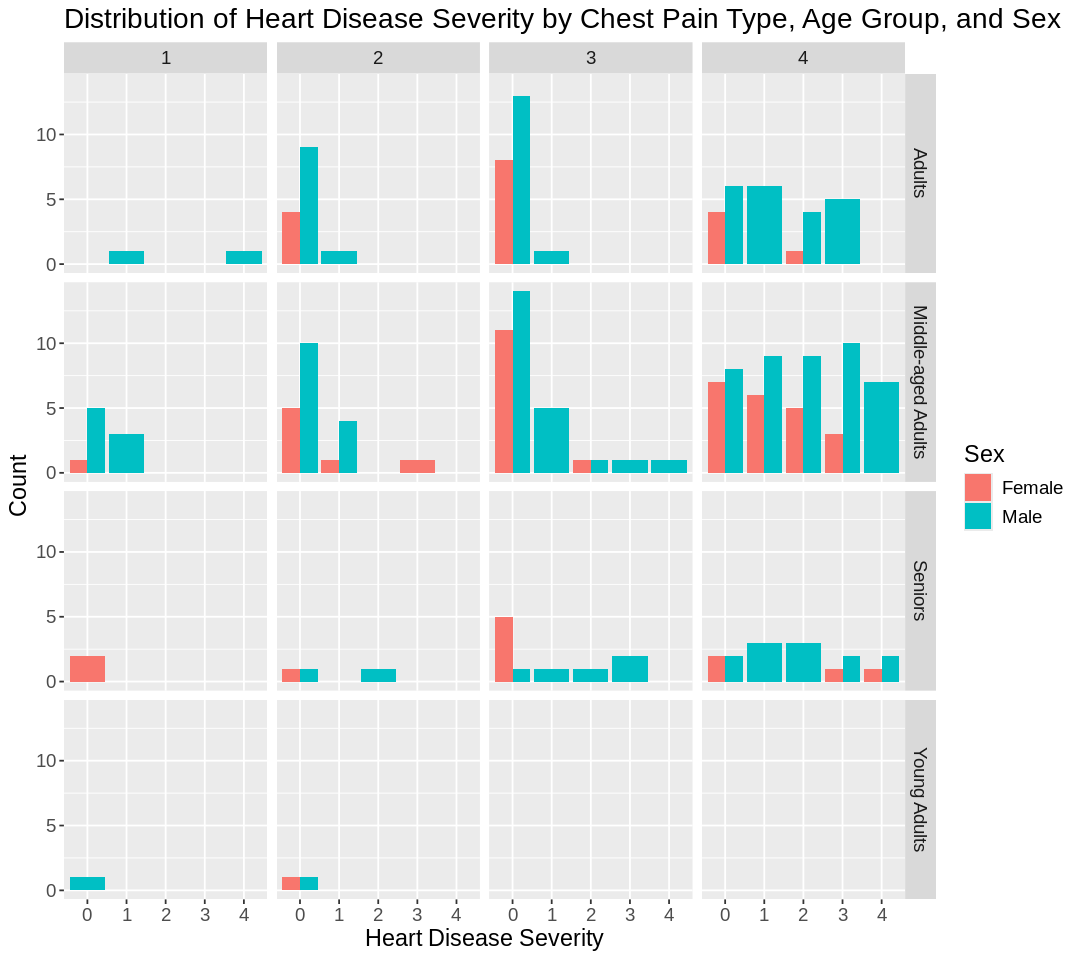

In [6]:
#Adjust the plot dimensions
options(repr.plot.height=8,repr.plot.width=9)

#Create the plot based on training data
train_plot<-cl_train|>
#Set the x-axis to heart disease severity and fill the color by sex
ggplot(aes(x=num,fill=sex))+
#Create a bar plot with counts, dodging bars side by side for different sexes
geom_bar(stat="count",position="dodge")+
#Create facets by age group(rows) and chest pain type(columns)
facet_grid(rows=vars(age_group),cols=vars(cp))+
#Add labels and title
labs(title = "Distribution of Heart Disease Severity by Chest Pain Type, Age Group, and Sex",
    x = "Heart Disease Severity",y = "Count",fill = "Sex")+
#Set the text size for the plot
theme(text=element_text(size=14))

#Display the plot
train_plot

**Data Analysis**

In [7]:
#Filter NA data
cl<-filter(cleveland,thal!="?")|>

#Define age groups
mutate(age_group = case_when(
    age <= 17 ~ "Children",
    age >= 18 & age <= 34 ~ "Young Adults",
    age >= 35 & age <= 49 ~ "Adults",
    age >= 50 & age <= 64 ~ "Middle-aged Adults",
    age >= 65 ~ "Seniors"))|>
mutate(age_group=as.factor(age_group))|>
mutate(num=as.factor(num))|> #Convert num to a factor
mutate(thal=as.numeric(thal))|> #Convert thal to a double

#select specific columns for further analysis
select(age_group,sex,cp,trestbps,thal,num)

In [8]:
#Split the data into training and testing sets with stratification
set.seed(666)
cl_split<-initial_split(cl,prop=0.75,strata=num)
#Training Set
cl_train<-training(cl_split)
#Testing Set
cl_test<-testing(cl_split)

In [9]:
#Define a recipe for preprocessing the data
cl_recipe<-recipe(num~sex+cp+trestbps+thal,data=cl_train)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#Define a KNN model specification
knn_spec<-nearest_neighbor(weight_func="rectangular",neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")

#Perform 5-fold cross-validation
cl_vfold<-vfold_cv(cl_train,v=5,strata=num)

#Define a range of neighbor values to be tuned
kgrid<-tibble(neighbors=c(3:15))

#Build the workflow
cl_fit<-workflow()|>
add_recipe(cl_recipe)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")
cl_fit

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.5576373,5,0.02614946,Preprocessor1_Model01
4,accuracy,multiclass,0.5308474,5,0.01414650,Preprocessor1_Model02
5,accuracy,multiclass,0.5391689,5,0.02233674,Preprocessor1_Model03
6,accuracy,multiclass,0.5661609,5,0.02240317,Preprocessor1_Model04
7,accuracy,multiclass,0.5837495,5,0.02556236,Preprocessor1_Model05
8,accuracy,multiclass,0.5786144,5,0.03376314,Preprocessor1_Model06
9,accuracy,multiclass,0.6150931,5,0.02223640,Preprocessor1_Model07
10,accuracy,multiclass,0.6015531,5,0.02580302,Preprocessor1_Model08
11,accuracy,multiclass,0.6108378,5,0.02497362,Preprocessor1_Model09


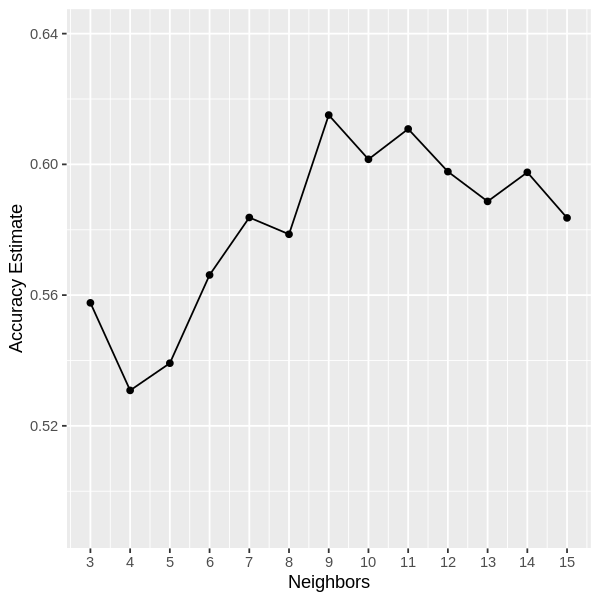

In [50]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k <- ggplot(cl_fit, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.49, 0.64)) # adjusting the y-axis
accuracy_versus_k

In [11]:
#Filter Young Adults from the dataset
cl_train_1<-cl_train|>
filter(age_group=="Young Adults")
#Too few data, cannot predict k

In [12]:
#Filter Adults from the dataset
cl_train_2<-cl_train|>
filter(age_group=="Adults")

#Define a recipe for preprocessing the data
cl_recipe_2<-recipe(num~sex+cp+trestbps+thal,data=cl_train_2)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#perform 5-fold cross-validation
cl_vfold_2<-vfold_cv(cl_train_2,v=5,strata=num)

#Build the workflow
cl_fit_2<-workflow()|>
add_recipe(cl_recipe_2)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold_2, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")
cl_fit_2

→ A | warning: No observations were detected in `truth` for level(s): '2', '4'
               Computation will proceed by ignoring those levels.

→ B | warning: No observations were detected in `truth` for level(s): '3', '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x2   B: x1

→ C | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x2   B: x1
There were issues with some computations   A: x2   B: x1   C: x2





neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.6871795,5,0.04891996,Preprocessor1_Model01
4,accuracy,multiclass,0.6884615,5,0.04052175,Preprocessor1_Model02
5,accuracy,multiclass,0.6871795,5,0.04244345,Preprocessor1_Model03
6,accuracy,multiclass,0.7358974,5,0.05089598,Preprocessor1_Model04
7,accuracy,multiclass,0.7358974,5,0.05089598,Preprocessor1_Model05
8,accuracy,multiclass,0.7512821,5,0.05552925,Preprocessor1_Model06
9,accuracy,multiclass,0.7653846,5,0.04880222,Preprocessor1_Model07
10,accuracy,multiclass,0.7653846,5,0.04880222,Preprocessor1_Model08
11,accuracy,multiclass,0.7653846,5,0.04880222,Preprocessor1_Model09


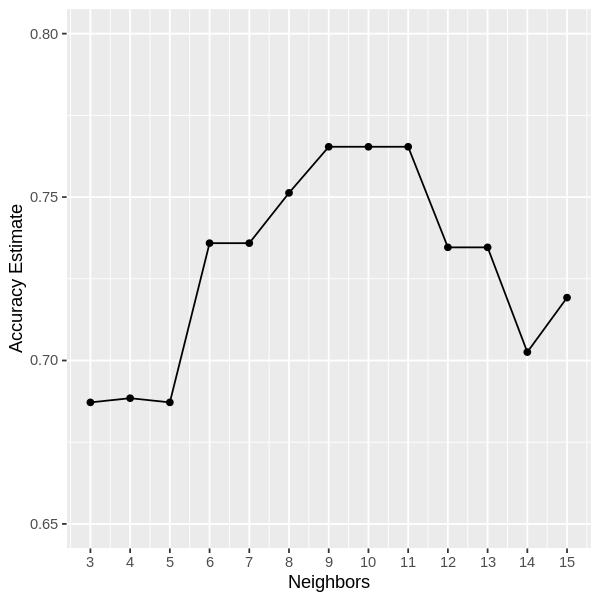

In [25]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k_2 <- ggplot(cl_fit_2, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.65, 0.8)) # adjusting the y-axis
accuracy_versus_k_2

In [14]:
#Filter Middle-aged Adults from the dataset
cl_train_3<-cl_train|>
filter(age_group=="Middle-aged Adults")

#Define a recipe for preprocessing the data
cl_recipe_3<-recipe(num~sex+cp+trestbps+thal,data=cl_train_3)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#perform 5-fold cross-validation
cl_vfold_3<-vfold_cv(cl_train_3,v=5,strata=num)

#Build the workflow
cl_fit_3<-workflow()|>
add_recipe(cl_recipe_2)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold_3, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")
cl_fit_3

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x2





neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.4258205,5,0.02108106,Preprocessor1_Model01
4,accuracy,multiclass,0.4646154,5,0.03044055,Preprocessor1_Model02
5,accuracy,multiclass,0.4572308,5,0.04056815,Preprocessor1_Model03
6,accuracy,multiclass,0.4719744,5,0.04381277,Preprocessor1_Model04
7,accuracy,multiclass,0.5110769,5,0.03750629,Preprocessor1_Model05
8,accuracy,multiclass,0.4803077,5,0.02128088,Preprocessor1_Model06
9,accuracy,multiclass,0.4796667,5,0.01764578,Preprocessor1_Model07
10,accuracy,multiclass,0.4713590,5,0.03058910,Preprocessor1_Model08
11,accuracy,multiclass,0.4710513,5,0.04056140,Preprocessor1_Model09


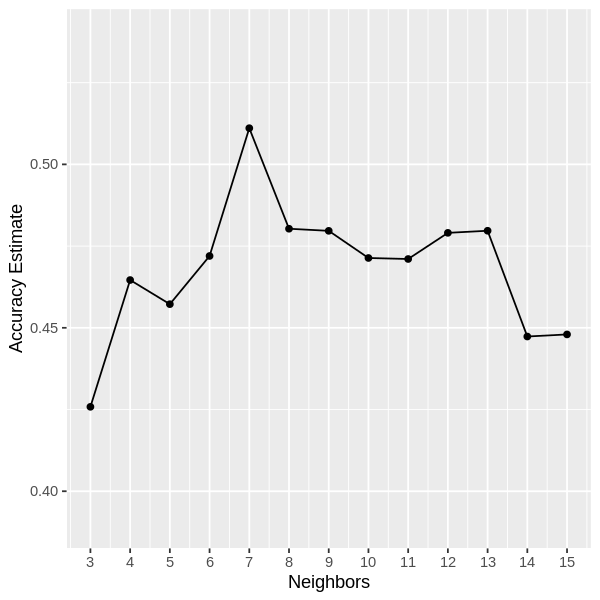

In [24]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k_3 <- ggplot(cl_fit_3, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.39, 0.54)) # adjusting the y-axis
accuracy_versus_k_3

In [16]:
#Filter Seniors from the dataset
cl_train_4<-cl_train|>
filter(age_group=="Seniors")

#Define a recipe for preprocessing the data
cl_recipe_4<-recipe(num~sex+cp+trestbps+thal,data=cl_train_4)|>
step_center(all_predictors())|> #Center all predictors
step_scale(all_predictors()) #Scale all predictors

#perform 5-fold cross-validation
cl_vfold_4<-vfold_cv(cl_train_4,v=5,strata=num)

#Build the workflow
cl_fit_4<-workflow()|>
add_recipe(cl_recipe_4)|>
add_model(knn_spec)|>
tune_grid(resamples = cl_vfold_4, grid = kgrid)|>
collect_metrics()|>
filter(.metric=="accuracy")
cl_fit_4

→ A | warning: No observations were detected in `truth` for level(s): '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

→ B | warning: No observations were detected in `truth` for level(s): '1', '2', '3', '4'
               Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,multiclass,0.4571429,5,0.05553288,Preprocessor1_Model01
4,accuracy,multiclass,0.3904762,5,0.02332847,Preprocessor1_Model02
5,accuracy,multiclass,0.3904762,5,0.02332847,Preprocessor1_Model03
6,accuracy,multiclass,0.3619048,5,0.02857143,Preprocessor1_Model04
7,accuracy,multiclass,0.4285714,5,0.06563833,Preprocessor1_Model05
8,accuracy,multiclass,0.4285714,5,0.06563833,Preprocessor1_Model06
9,accuracy,multiclass,0.4285714,5,0.06563833,Preprocessor1_Model07
10,accuracy,multiclass,0.4285714,5,0.06563833,Preprocessor1_Model08
11,accuracy,multiclass,0.4285714,5,0.06563833,Preprocessor1_Model09


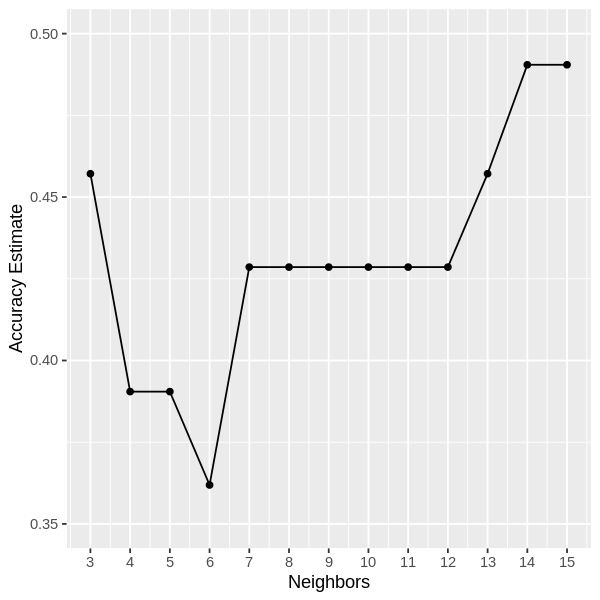

In [23]:
options(repr.plot.width=5,repr.plot.height=5)

#Create a plot of accuracy versus the number of neighbors
accuracy_versus_k_4 <- ggplot(cl_fit_4, aes(x = neighbors, y = mean))+
geom_point() + #Add points to plot
geom_line() + #Connect points with a line
labs(x = "Neighbors", y = "Accuracy Estimate") + #Label axis
scale_x_continuous(breaks = seq(3, 15, by = 1)) +  # adjusting the x-axis
scale_y_continuous(limits = c(0.35, 0.50)) # adjusting the y-axis
accuracy_versus_k_4

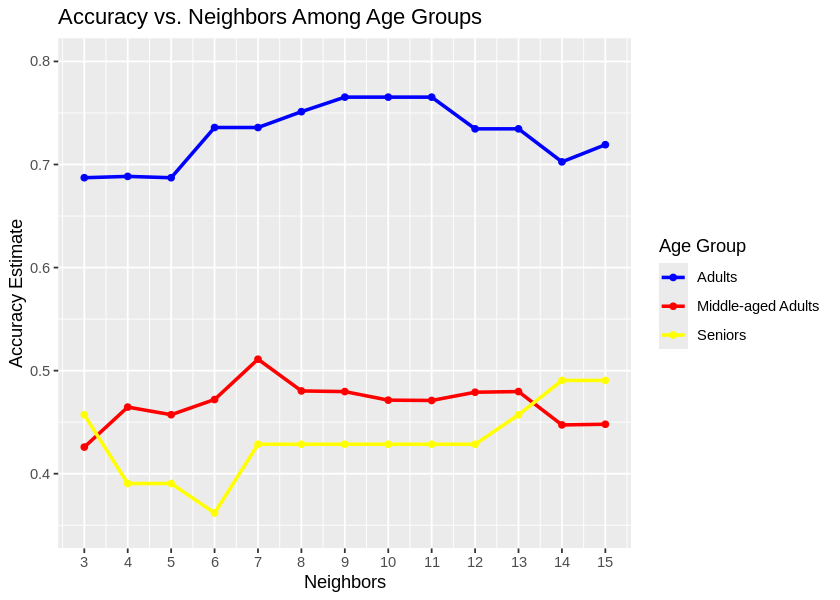

In [68]:
options(repr.plot.width=7,repr.plot.height=5)
# Define the plot with corrected color mappings and scale definitions
together_plot <- ggplot() +
geom_line(data = cl_fit_2, aes(x = neighbors, y = mean, color = "2"), size = 1) +
geom_point(data = cl_fit_2, aes(x = neighbors, y = mean, color = "2")) +
geom_line(data = cl_fit_3, aes(x = neighbors, y = mean, color = "3"), size = 1) +
geom_point(data = cl_fit_3, aes(x = neighbors, y = mean, color = "3")) +
geom_line(data = cl_fit_4, aes(x = neighbors, y = mean, color = "4"), size = 1) +
geom_point(data = cl_fit_4, aes(x = neighbors, y = mean, color = "4")) +
scale_y_continuous(limits = c(0.35, 0.8)) +
labs(x = "Neighbors", y = "Accuracy Estimate", title = "Accuracy vs. Neighbors Among Age Groups") +
scale_color_manual(values = c("2" = "blue", "3" = "red", "4" = "yellow"),
                     labels = c("Adults", "Middle-aged Adults", "Seniors"),
                     name = "Age Group")+
scale_x_continuous(breaks = seq(3, 15, by = 1))

# Display the plot
together_plot

---
## Method
    - My goal is to use k-nearest neighbors(KNN) classification to predict the severity of heart disease based on chest pain type, resting blood pressure, and thalassemia status across all age groups and sexes. The following columns will be seleceted for analysis: cp(chest pain type), trestbps(resting blood pressure), thal(thalassemia status), age_group(age group), sex(sex), and num(serverity of heart disease). Sex will be convert into numerical values before the classification and the dataset will be divided in to subgroups by age_group. The number of neighbors(k) will be optimized using cross-validation to determine the best value for accurate predictions. The model's performance will be evaluated on the testing dataset using metrics such as accuracy, precision, and recall. Furthermore, a confusion matrix will be plotted to visualize the model's performance.

---
## Expected Outcome and Significance:
    - Expect to find: I expected to find a significant relationship between the selected predictor variables and the severity of heart disease across age groups. For example, I aim to determine which age group with the specific attributes will likely to be diagnosed with heart disease.
    - Impact of findings: The findings could have a substantial impact on the early disgnosis and treatment of heart disease. Accurate predictions of heart disease severity could assist healthcare professionals in making informed decisions, saving more lives.
    - Future questions: 
        - Can the model be extended to predict other cardiovascular conditions beyond the severity of heart disease?
        - How to improve the accuracy of the KNN model with addtional features?

---